In [1]:
import argparse

import numpy as np
import torch
import torch.nn as nn
import fnmatch
import os

from src.i3dpt import I3D

rgb_pt_checkpoint = 'model/model_rgb.pth'

## Set up the gpu and the model

In [2]:
import pycuda.driver as cuda
import pycuda.autoinit # Necessary for using its functions
cuda.init() # Necesarry for using its functions

num = cuda.Device.count()
print("%d device(s) found:"%num)
for i in range(num):
    print(cuda.Device(i).name(), "(Id: %d)"%i)

ImportError: No module named 'pycuda'

In [ ]:
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
torch.cuda.set_device(0)
torch.cuda.current_device()
device = torch.device('cuda:0')

In [ ]:
if device.type == 'cuda':
    i = 0
    print(torch.cuda.get_device_name(i))
    print(torch.cuda.get_device_properties(i).total_memory)
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(i)/1024**3,1), 'GB')

In [ ]:
torch.cuda.current_device()

In [ ]:
torch.cuda.get_device_capability(0)

In [4]:
#i3d_rgb = I3D(num_classes=400, modality='rgb').to(device)
i3d_rgb = I3D(num_classes=400, modality='rgb').cuda()

In [5]:
#i3d_rgb.eval()
i3d_rgb.load_state_dict(torch.load(rgb_pt_checkpoint))

In [6]:
i3d_rgb = nn.DataParallel(i3d_rgb)

In [7]:
rgb_sample = np.load('data/kinetic-samples/v_CricketShot_g04_c01_rgb.npy').transpose(0, 4, 1, 2, 3)

In [8]:
# sample_var = torch.autograd.Variable(torch.from_numpy(rgb_sample)).to(device)
sample_var = torch.autograd.Variable(torch.from_numpy(rgb_sample)).cuda()
print(sample_var.shape)
out_var, out_logit = i3d_rgb(sample_var)
print(out_var.shape)
out_tensor = out_var.data.cpu()

torch.Size([1, 3, 79, 224, 224])
torch.Size([1, 1024])


## Good to go, now test on sample data! 

### Extract i3d features

To be able to run this step:
1. Download the Kinetics dataset -> download.py
2. Extract the frames by ffmpeg -> extract_frames.py
3. Preprocess the frames and create npy files ->read_frames.py

In [9]:
rgb_sample = np.load("../ActivityNet/Crawler/Kinetics/mini_data_frames_rgb/abseiling__aQSjArgAqA_000123_000133.npy")
sample = torch.from_numpy(rgb_sample).unsqueeze(0)
print("shape now:", sample.shape)
#sample_var = torch.autograd.Variable(sample).to(device)
sample_var = torch.autograd.Variable(sample).cuda()
print(sample_var.shape)
out_var, _ = i3d_rgb(sample_var)
print(out_var.shape)
out_tensor = out_var.data.cpu()

shape now: torch.Size([1, 3, 52, 224, 224])
torch.Size([1, 3, 52, 224, 224])
torch.Size([1, 1024])


In [10]:
sample_var = sample_var[:, :, :10, :, :]

In [11]:
i3d_rgb(sample_var)

(tensor([[0.1719, 0.1271, 0.2577,  ..., 0.2460, 0.2247, 0.1889]],
        device='cuda:0', grad_fn=<GatherBackward>),
 tensor([[0.1719, 0.1271, 0.2577,  ..., 0.2460, 0.2247, 0.1889]],
        device='cuda:0', grad_fn=<GatherBackward>))

In [301]:
#frame_dir = "../ActivityNet/Crawler/Kinetics/val400_data_frames_rgb/"
frame_dir = "../ActivityNet/Crawler/Kinetics/test400_100_frames_rgb/"

In [ ]:
action_classes = [
    'swimming breast stroke',
    'jogging',
    "digging",
    'riding horse',
    'side kick',
    'punching bag',
    'marching',
    'breakdancing',
    #'somersaulting',
    'capoeira',
    'robot dancing',
    'air drumming',
    'clapping',
    #'headbanging',
    'eating burger',
    'laughing',
    'crying',
    'bartending',
    'bowling',
    'snowboarding',
    'beatboxing',
    'playing cello',
    'playing piano',
    "singing"
]

In [302]:
action_classes_all = set()
for dirpath, dirs, files in os.walk(frame_dir):
    for filename in fnmatch.filter(files, '*.npy'):
        action = filename.split("_")[0]
        action_classes_all.add(action)

In [303]:
len(action_classes_all)

400

In [304]:
hele = "skiing (ama soyle boyle)"
(hele.split(" (")[0]).split(" ")

['skiing']

In [383]:
n = 200 # number of classes

import random
action_classes = set(random.sample(action_classes_all, n))

In [384]:
for a in action_classes:
    words = a.split(" (")[0]
    action_classes.remove(a)
    action_classes.add(words)

In [385]:
word_dict = {}
not_exist = set()
for a in action_classes:
    words = a.split(" (")[0]
    words = words.split(" ")
    glove_sums = 0
    for w in words:
        try:
            glove_sums += glove_model[w]
        except:
            print(a)
            not_exist.add(a)
            break
            
action_classes.difference_update(not_exist)

massaging person's head
slacklining
deadlifting
situp
passing American football
trapezing
barbequing
faceplanting
unboxing
jumpstyle dancing


In [ ]:
action_classes

In [387]:
for a in action_classes:
    words = a.split(" (")[0]
    words = words.split(" ")
    glove_sums = 0
    for w in words:
        glove_sums += glove_model[w]
    glove_sums /= len(words)
    word_dict[a] = glove_sums

In [388]:
len(action_classes)

190

In [389]:
vid_features = {}
vid_ids = []
for dirpath, dirs, files in os.walk(frame_dir):
    for filename in fnmatch.filter(files, '*.npy'):
        action = filename.split("_")[0]
        if action in action_classes:
            rgb_sample = np.load(dirpath+filename)
            sample = torch.from_numpy(rgb_sample).unsqueeze(0)
            if sample.shape[2] > 10: # should be bigger than the kernel size 
                vid_ids.append(filename)
                # sample_var = torch.autograd.Variable(sample).to(device)
                sample_var = torch.autograd.Variable(sample)
                try:
                    out_var, _ = i3d_rgb(sample_var)
                except Exception as e: 
                    print("error: ", e)
                    print("   shape: ", sample_var.shape)
                vid_features[filename] = out_var.data.cpu().numpy()

In [ ]:
next(i3d_rgb.parameters()).is_cuda

In [ ]:
vid_features.keys()

In [ ]:
import pickle
fname = 'pickle/kinetics_i3d.pkl'
pickle.dump(vid_features, open (fname, 'wb'))

In [ ]:
fname = 'anet_c3d.pkl'
vids = pickle.load(open(fname, 'rb'))

### Extract word features

In [17]:
from argparse import ArgumentParser
import glob
import json
import os
import numpy as np
import torch
import re
import sys
import array

In [18]:
vectors = array.array('d')
print("Loading Glove Model")
gloveFile = '../glove.6B.300d.txt'
f = open(gloveFile, 'r', encoding="utf-8")
dct = {}
glove_model = {}
n_words = 400000 #### TAKE THE MOST FREQUENT N WORDS!!!
for i, line in enumerate(f):
    splitLine = line.split()
    word = splitLine[0]
    entries = splitLine[1:]
    embedding = np.array([float(val) for val in entries], dtype=np.float32)
    glove_model[word] = embedding
    dct[word] = i
    vectors.extend(float(x) for x in entries)
    if i == n_words - 1:
        break

print("Done.", len(glove_model), " words loaded!")
#return model

Loading Glove Model
Done. 400000  words loaded!


###### 

In [19]:
len(vectors)
no_vectors = len(dct)

In [20]:
no_vectors*300 == len(vectors)

True

In [21]:
# no_components = len(v) # What is v?!?!
no_vectors = len(dct)    
no_components = 300
word_vectors = (np.array(vectors).reshape(no_vectors,no_components))
word_biases = np.zeros(no_vectors)
items_iterator = dct.items()
inverse_dictionary = {v: k for k, v in items_iterator}

In [22]:
len(glove_model["somersaulting"]), len(glove_model["bellydancing"])

KeyError: 'bellydancing'

In [130]:
def _similarity_query(word_vectors, word_vec, number, inverse_dictionary):
    
    dst = (np.dot(word_vectors, word_vec)
           / np.linalg.norm(word_vectors, axis=1)
           / np.linalg.norm(word_vec))
    word_ids = np.argsort(-dst)

    return [(inverse_dictionary[x], dst[x]) for x in word_ids[:number]
            if x in inverse_dictionary]

def most_similar(word_vectors, dictionary, word, number=5):
    try:
        word_idx = dictionary[word]
    except KeyError:
        raise Exception('Word not in dictionary')

    return _similarity_query(word_vectors, word_vectors[word_idx], number, inverse_dictionary)[1:]

In [ ]:
# should we use ing words?
word_dict = {
    'abseiling': glove_model['abseiling'],
    'air drumming': glove_model['drumming'],
    'answering questions': glove_model['answering'],
    'applauding': glove_model['applauding'],
    'applying cream': np.average([glove_model['applying'], glove_model['cream']], axis=0), # applying cream?
    'archery': glove_model['archery'], 
    'arm wrestling': np.average([glove_model['wrestling'], glove_model['arm']], axis=0), # arm wrestling
    'arranging flowers': np.average([glove_model['arranging'], glove_model['flowers']], axis=0), # arranging flowers
    'assembling computer': np.average([glove_model['assembling'], glove_model['computer']], axis=0), # assembling computer
    'auctioning': glove_model['auctioning'],
    'baby waking up': np.average([glove_model['baby'], glove_model['wakeup']], axis=0), # baby waking up
    'baking cookies': np.average([glove_model['baking'], glove_model['cookies']], axis=0), # baking cookies
    'balloon blowing': np.average([glove_model['balloon'], glove_model['blowing']], axis=0), 
    'bandaging': glove_model['bandaging'],
    'barbequing': glove_model['barbeque'],
    'bartending': glove_model['bartending'],
    'beatboxing': glove_model['beatboxing'],
    'bee keeping': glove_model['beekeeping'],
    #'belly dancing': glove_model['bellydance'],
    'bench pressing': np.average([glove_model['weight'], glove_model['lifting']], axis=0), 
    'swimming breast stroke': glove_model['swimming'],
    'jogging': glove_model['jogging'],
    'digging': glove_model['digging'],
    'riding horse': glove_model['riding'], #### add horse?
    'side kick': glove_model['sidekick'],
    'punching bag': glove_model['punching'],
    'marching': glove_model['marching'],
    'breakdancing': glove_model['breakdancing'],
    #'somersaulting': glove_model['somersaulting'],
    'capoeira': glove_model['capoeira'],
    'robot dancing': np.average([glove_model['robot'], glove_model['dancing']], axis=0),
    'laughing': glove_model['laughing'],
    'crying': glove_model['crying'],
    #'headbanging': glove_model['headbanging'],
    'eating burger': glove_model['eating'],   ### add burger?
    'clapping': glove_model['clapping'],
    'bowling': glove_model['bowling'],
    'singing': glove_model['singing'],
    'snowboarding': glove_model['snowboarding'],
    'capoeira': glove_model['capoeira'],
    'playing piano': np.average([glove_model['playing'], glove_model['piano']], axis=0),
    'playing cello': np.average([glove_model['playing'], glove_model['cello']], axis=0)
}

person's
jumpstyle
breadcrumbing
(not
cat)
deadlifting
slacklining


In [312]:
for a in action_classes:
    if a not in word_dict:
        print(a)

### Split train + test

In [390]:
len(dct.keys())

400000

In [53]:
vid_ids[7].split('_')

['pushing cart', 'tVG1cCloXuM', '000004', '000014.npy']

In [391]:
print("Total videos:" , len(vid_ids))
print("total labels: ", len(word_dict.keys()))

Total videos: 14263
total labels:  190


In [392]:
label_counter = {}
for v in vid_ids:
    label = v.split('_')[0]
    try:
        label_counter[label].append(v)
    except KeyError:
        label_counter[label] = [v]

In [ ]:
for v in label_counter:
    print(v, len(label_counter[v]))

In [105]:
vid_dict = {}
vid_vectors = []
for v in vid_ids:
    label = v.split('_')[0]
    feat = vid_features[v]
    #print(len(feat[0]))
    try:
        vid_dict[label].append(feat[0])
    except KeyError:
        vid_dict[label] = [feat[0]]

j = 0
vid_dict_ind = {}
for k,v in vid_dict.items():
    sums = [0]*1024
    for e in v:
        sums += e
    sums = sums / len(v)
    vid_dict[k] = sums
    vid_dict_ind[k] = j
    j += 1
    vid_vectors.append(sums)
        
items_iterator_vid = vid_dict_ind.items()
inverse_vid_dictionary = {v: k for k, v in items_iterator_vid}

In [106]:
sampl = vid_ids[7]
v_sampl = vid_features[sampl]
print(v_sampl[0])
v_sampl.shape

[0.17831162 0.09592676 0.18540394 ... 0.19039199 0.13865879 0.2214011 ]


(1, 1024)

In [904]:
_similarity_query(vid_vectors, v_sampl[0], 10, inverse_vid_dictionary)

[('tickling', 0.9820670993327837),
 ('getting a tattoo', 0.9808556450625217),
 ('eating watermelon', 0.9801278543463946),
 ('hugging', 0.9800894620913595),
 ('massaging feet', 0.9799010141827584),
 ('washing hair', 0.9797260852306909),
 ('crying', 0.9795987738340197),
 ('drinking shots', 0.9794118267174158),
 ('reading book', 0.9794117965496962),
 ('petting cat', 0.9793869743345667)]

In [58]:
vid_dict["laughing"]

KeyError: 'laughing'

In [393]:
import random
train_ids, val_ids, test_ids = [], [], []
for k, v in label_counter.items():
    p = len(v)* 20 // 100
    ind = random.sample(range(len(v)), p)
    val_ind = ind[:len(ind)//2]
    test_ind = ind[len(ind)//2:]
    for i, e in enumerate(v):
        if i in test_ind:
            test_ids.append(e)
        elif i in val_ind:
            val_ids.append(e)
        else:
            train_ids.append(e)

In [394]:
len(train_ids), len(val_ids), len(test_ids)

(11485, 1337, 1441)

### Define dataset

In [395]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from random import randint

class MultimodalDataset(Dataset):

    def __init__(self, train_ids, vids, words, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train_ids = train_ids
        self.vids = vids
        self.caps = words

    def __len__(self):
        return len(self.train_ids)

    def __getitem__(self, idx):
        vid_id = self.train_ids[idx]
        vid_feat = self.vids[vid_id]
        word_feat = self.caps[vid_id.split('_')[0]]
        word_feat = np.expand_dims(word_feat, axis=0)
        label = vid_id.split("_")[0]
        
        neg_sample = False
        n_vid_id = vid_id
        n_label = label
        while not neg_sample:
            rand = randint(0, len(self.train_ids)-1)
            if rand == idx:
                break
            n_vid_id = self.train_ids[rand]
            n_label = n_vid_id.split("_")[0]
            if n_label is label:
                break
            neg_sample=True
        
        n_vid_feat = self.vids[n_vid_id]
        n_word_feat = self.caps[n_vid_id.split('_')[0]]
        n_word_feat = np.expand_dims(n_word_feat, axis=0)
        
        sample = {'vid_feat': vid_feat, 'word_feat': word_feat, 'label':label, 
                  'n_vid_feat': n_vid_feat, 'n_word_feat':n_word_feat, 'n_label':n_label }

        return sample

In [396]:
batch_size = 4
train_data = MultimodalDataset(train_ids, vids=vid_features, words=word_dict)
val_data = MultimodalDataset(val_ids, vids=vid_features, words=word_dict)
test_data = MultimodalDataset(test_ids, vids=vid_features, words=word_dict)
dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
dataloaders_dict = {
    'train' : DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True),
    'val': DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True),
    'test': DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
}

In [397]:
data_sample = train_data[10]
print(data_sample['label']," - ", data_sample['n_label'])
word = data_sample['n_word_feat']

presenting weather forecast  -  whistling


In [398]:
test_data[0]['word_feat'].shape

(1, 300)

### Extract another dataset -> IAPRCTC12 - wiki

In [ ]:
def readDATA(fileDir, vis=False):
    words,vectors = [], []
    with open(fileDir) as infile: # wherever you store the vectors
        for line in infile:
            line = line.strip()
            line = line.split(",")
            words.append(line[0])
            vect = line[1:len(line)]
            vect = [float(t) for t in vect]
            if vis:
                vect = np.expand_dims(vect, axis=0)
            vectors.append(vect)
        vectors = np.array(vectors)
    return words, vectors

In [ ]:
lb_ts, EMB_ts_vis = readDATA('iaprtc/TS_vis_vgg128.csv', True)
_, EMB_ts_lang = readDATA('iaprtc/TS_lang_biGRU.csv')
lb_tr, EMB_tr_vis = readDATA('iaprtc/TR_vis_vgg128.csv', True)
_, EMB_tr_lang = readDATA('iaprtc/TR_lang_biGRU.csv')

In [ ]:
len(lb_ts), len(EMB_ts_vis), len(EMB_ts_lang), len(lb_tr)

In [ ]:
EMB_ts_lang.shape

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

class MultimodalDataset2(Dataset):

    def __init__(self, vids, words, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.vids = vids
        self.caps = words

    def __len__(self):
        return len(self.vids)

    def __getitem__(self, idx):
        #vid_id = self.train_ids[idx]
        vid_feat = self.vids[idx]
        word_feat = self.caps[idx]
        word_feat = np.expand_dims(word_feat, axis=0)

        sample = {'vid_feat': vid_feat, 'word_feat': word_feat}

        return sample

In [ ]:
batch_size = 4
train_data = MultimodalDataset2(vids=EMB_tr_vis[:-2000], words=EMB_tr_lang[:-2000])
val_data = MultimodalDataset2(vids=EMB_tr_vis[-2000:], words=EMB_tr_lang[-2000:])
test_data = MultimodalDataset2(vids=EMB_ts_vis, words=EMB_ts_lang)
dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
dataloaders_dict = {
    'train' : DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True),
    'val': DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True),
    'test': DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
}

In [ ]:
a = [1, 2, 3, 4 , 5, 6]
a[:-2]

### Define autoencoder

In [399]:
class VideoEncoder(torch.nn.Module):

    def __init__(self,
                 C,
                 N,
                 num_feats,
                 drop_out):
        super(VideoEncoder, self).__init__()

        self.C = C
        self.N = N
        self.num_feats = num_feats
        mid = int((N+C)/2)
        
        self.fc = nn.Sequential(
            nn.Linear(num_feats, C),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(C, mid),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(mid, N)
        )     

    def forward(self, inp):
        out = self.fc(inp)
        return out
    
class VideoDecoder(torch.nn.Module):

    def __init__(self,
                 C,
                 N,
                 num_feats,
                 drop_out):
        super(VideoDecoder, self).__init__()

        self.C = C
        self.N = N
        self.num_feats = num_feats
        mid = int((num_feats+C)/2)
        
        self.fc = nn.Sequential(
            nn.Linear(N, C),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(C, mid),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(mid, num_feats)
        )  
        
    def forward(self, inp):
        out = self.fc(inp)
        return out
    
class WordEncoder(torch.nn.Module):

    def __init__(self,
                 L,
                 N,
                 num_feats,
                 drop_out):
        super(WordEncoder, self).__init__()

        self.L = L
        self.N = N
        self.num_feats = num_feats
        mid = int((L+N)/2)
        
        self.fc = nn.Sequential(
            nn.Linear(num_feats, L),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(L, mid),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(mid, N)
        )

    def forward(self, inp):
        out = self.fc(inp)
        return out
    
class WordDecoder(torch.nn.Module):

    def __init__(self,
                 L,
                 N,
                 num_feats,
                 drop_out):
        super(WordDecoder, self).__init__()

        self.L = L
        self.N = N
        self.num_feats = num_feats
        mid = int((L+num_feats)/2)
        self.fc = nn.Sequential(
            nn.Linear(N, L),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(L, mid),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(mid, num_feats)
        )

    def forward(self, inp):
        out = self.fc(inp)
        return out

In [400]:
batch_size = 1
C = 300 # mid bottleneck for video
N = 50 # representation dim
V = 1024 # feature vector size for i3d
enc_vid = VideoEncoder(C=C, N=N, num_feats=V)
dec_vid = VideoDecoder(C=C, N=N, num_feats=V)

TypeError: __init__() missing 1 required positional argument: 'drop_out'

In [ ]:
enc_vid.to(device)
dec_vid.to(device)

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
ff_0 = nn.Linear(1024, 300).to(device)
ff = nn.Linear(300, 50).to(device)

In [ ]:
#vid_sample = vid_sample.squeeze(0)
#vid_sample.shape
v_sampl.shape

In [ ]:
k = ff_0(vid_sample)

In [ ]:
k.shape

In [ ]:
m = nn.ReLU()
k = m(k)

In [ ]:
k.shape

In [ ]:
ff(k).shape

In [ ]:
vid_sample = torch.from_numpy(test_data[0]['vid_feat']).float().to(device)
h = enc_vid(vid_sample)
h.shape

In [ ]:
out = dec_vid(h)

In [ ]:
out.shape

In [ ]:
vid_sample.shape

In [ ]:
L = 100 # mid bottleneck for word
N = 50 # representation dim
D = 300 # glove vector dim
enc_word = WordEncoder(L=L, N=N, num_feats=D)
dec_word = WordDecoder(L=L, N=N, num_feats=D)

In [ ]:
word_sample = torch.from_numpy(test_data[0]['word_feat']).float().to(device)
enc_word.to(device)
dec_word.to(device)
h_w = enc_word(word_sample)

In [ ]:
h_w.shape

In [ ]:
w_out = dec_word(h_w)

In [ ]:
v_to_w = dec_word(h)

In [ ]:
w_to_v = dec_vid(h_w)

In [ ]:
w_to_v.shape, vid_sample.shape

In [ ]:
loss = nn.MSELoss()
loss(w_to_v ,vid_sample.view(1, 1, 1024))

In [ ]:
loss(v_to_w, word_sample.view(1, 1, 300))

### Define parameters

In [401]:
num_epochs = 300
batch_size = 512
learning_rate = 1e-3
weight_decay = 1e-5
drop_out = 0.5

dataset= 'kinetics'

if dataset is 'kinetics':
    C = 600 # mid bottleneck for video
    N = 150 # representation dim
    V = 1024 # feature vector size for i3d
    L = 200 # mid bottleneck for word
    D = 300 # glove vector dim
elif dataset is 'wiki':
    C = 80 # mid bottleneck for video
    N = 48 # representation dim
    V = 128 # feature vector size for vgg
    L = 100 # mid bottleneck for text
    D = 64 # gru feature size 

print("Video autoencoder::: ")
enc_vid = VideoEncoder(C=C, N=N, num_feats=V, drop_out=drop_out)
dec_vid = VideoDecoder(C=C, N=N, num_feats=V, drop_out=drop_out)

print("Word autoencoder::: ")
enc_word = WordEncoder(L=L, N=N, num_feats=D, drop_out=drop_out)
dec_word = WordDecoder(L=L, N=N, num_feats=D, drop_out=drop_out)


optim1 = torch.optim.Adam(enc_vid.parameters(), lr=learning_rate, weight_decay = weight_decay)
optim2 = torch.optim.Adam(dec_vid.parameters(), lr=learning_rate, weight_decay = weight_decay)
optim3 = torch.optim.Adam(enc_word.parameters(), lr=learning_rate, weight_decay = weight_decay)
optim4 = torch.optim.Adam(dec_word.parameters(), lr=learning_rate, weight_decay = weight_decay)
criterion = nn.MSELoss()

Video autoencoder::: 
Word autoencoder::: 


In [402]:
if dataset is 'kinetics':
    train_data = MultimodalDataset(train_ids, vids=vid_features, words=word_dict)
    val_data = MultimodalDataset(val_ids, vids=vid_features, words=word_dict)
    test_data = MultimodalDataset(test_ids, vids=vid_features, words=word_dict)
    dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    dataloaders_dict = {
        'train' : DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True),
        'val': DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True),
        'test': DataLoader(dataset=test_data, batch_size=1, shuffle=True)
    }
elif dataset is 'wiki_small':
    train_data = MultimodalDataset2(vids=EMB_tr_vis[:700], words=EMB_tr_lang[:700])
    val_data = MultimodalDataset2(vids=EMB_tr_vis[700:800], words=EMB_tr_lang[700:800])
    test_data = MultimodalDataset2(vids=EMB_ts_vis[:100], words=EMB_ts_lang[:100])
    dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    dataloaders_dict = {
        'train' : DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True),
        'val': DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True),
        'test': DataLoader(dataset=test_data, batch_size=1, shuffle=True)
    }
elif dataset is 'wiki':
    train_data = MultimodalDataset2(vids=EMB_tr_vis[:14131], words=EMB_tr_lang[:14131])
    val_data = MultimodalDataset2(vids=EMB_tr_vis[14131:15898], words=EMB_tr_lang[14131:15898])
    test_data = MultimodalDataset2(vids=EMB_ts_vis[:1767], words=EMB_ts_lang[:1767])
    dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    dataloaders_dict = {
        'train' : DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True),
        'val': DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True),
        'test': DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
    }

In [328]:
len(word_dict['dancing macarena'])

KeyError: 'dancing macarena'

In [213]:
EMB_tr_vis.shape

NameError: name 'EMB_tr_vis' is not defined

## Train the model

In [403]:
enc_vid = enc_vid.to(device)
dec_vid = dec_vid.to(device)
enc_word = enc_word.to(device)
dec_word = dec_word.to(device)

In [404]:
enc_vid = nn.DataParallel(enc_vid)
dec_vid = nn.DataParallel(dec_vid)
enc_word = nn.DataParallel(enc_word)
dec_word = nn.DataParallel(dec_word)

In [405]:
len(dataloaders_dict['train'].dataset), len(dataloaders_dict['val'].dataset), len(dataloaders_dict['test'].dataset)

(11485, 1337, 1441)

In [406]:
print(enc_vid)

DataParallel(
  (module): VideoEncoder(
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=600, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5)
      (3): Linear(in_features=600, out_features=375, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.5)
      (6): Linear(in_features=375, out_features=150, bias=True)
    )
  )
)


In [407]:
import time
import copy

since = time.time()

train_acc_history = []
val_acc_history = []

best_enc_vid = VideoEncoder(C=C, N=N, num_feats=V, drop_out=drop_out)
best_dec_vid = VideoDecoder(C=C, N=N, num_feats=V, drop_out=drop_out)
best_enc_word = WordEncoder(L=L, N=N, num_feats=D, drop_out=drop_out)
best_dec_word = WordDecoder(L=L, N=N, num_feats=D, drop_out=drop_out)


best_loss = 1000000.0

num_epochs=300

for epoch in range(num_epochs):

    for phase in ['train', 'val']:
        if phase == 'train':
            # Set model to training mode
            enc_vid.train()
            dec_vid.train()
            enc_word.train()
            dec_word.train()
        else:
            enc_vid.eval()
            dec_vid.eval()
            enc_word.eval()
            dec_word.eval()
            
        running_loss = 0.0
        l_recons, l_joint, l_cross = 0.0, 0.0, 0.0
        running_l_recons, running_l_joint, running_l_cross = 0.0, 0.0, 0.0
        running_l_rank = 0.0
        optim1.zero_grad()
        optim2.zero_grad()
        optim3.zero_grad()
        optim4.zero_grad()
        
        for data in dataloaders_dict[phase]:
            
            video = data["vid_feat"].float().to(device)
            word = data["word_feat"].float().to(device)
            
            n_video = data["n_vid_feat"].float().to(device)
            n_word = data["n_word_feat"].float().to(device)

            with torch.set_grad_enabled(phase == 'train'):
                try:
                    mid_video = enc_vid(video)
                except RuntimeError as err:
                    print(video.shape)
                    print("mid video cannot create: ", err)
                    break
                out_video = dec_vid(mid_video)
                
                loss1 = criterion(out_video, video)

                mid_word = enc_word(word)
                out_word = dec_word(mid_word)

                
                loss2 = criterion(out_word, word)

                l_recons = loss1+loss2
                
                cos = nn.CosineSimilarity(dim=2, eps=1e-6)
                
                n_mid_word = enc_word(n_word)
                
                try:
                    sim1 = cos(mid_video, mid_word)
                    sim2 = cos(mid_video, n_mid_word)
                except:
                    break
                
                marg_loss = torch.nn.MarginRankingLoss(margin=0.2)
                target = torch.ones(len(sim1)).to(device)
                #print("mid word: ", mid_video.shape)
                #print("sim1: ", sim1.shape, " sim2: ", sim2.shape)
                l_rank_joint = marg_loss(sim1, sim2, target)
                
                
                l_joint = criterion(mid_video, mid_word)

                cross_words = dec_word(mid_video)
                cross_video = dec_vid(mid_video)
                l_cross = criterion(cross_words, word) + criterion(cross_video, video)

                alpha1, alpha2, alpha3 = 1, 10, 10
                loss = alpha1*l_recons + alpha2*l_rank_joint + alpha3*l_cross
                
                running_loss += loss.item()
                running_l_recons += l_recons.item()
                running_l_joint += l_joint.item()
                running_l_cross += l_cross.item()
                running_l_rank += l_rank_joint.item()

                if phase == 'train':
                    optim1.zero_grad()
                    optim2.zero_grad()
                    optim3.zero_grad()
                    optim4.zero_grad()
                    loss.backward()
                    optim1.step()
                    optim2.step()
                    optim3.step()
                    optim4.step()
            
        epoch_loss = running_loss #/ len(dataloaders_dict[phase].dataset)
        
        if phase == 'train':
            train_acc_history.append(epoch_loss)
        
        #loss = running_loss
        if phase == 'val':
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_enc_vid = copy.deepcopy(enc_vid)
                best_dec_vid = copy.deepcopy(dec_vid)
                best_enc_word = copy.deepcopy(enc_word)
                best_dec_word = copy.deepcopy(dec_word)
            val_acc_history.append(epoch_loss)
            if epoch%5 ==0:
                print('epoch [{}/{}], epoch_loss:{:.8f}, l_recons:{:.8f}, l_joint:{:.8f}, l_rank:{:.8f}, l_cross:{:.8f}'
                      .format(epoch + 1, num_epochs, epoch_loss, running_l_recons, running_l_joint, running_l_rank, running_l_cross))
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_loss))

torch.save(enc_vid.state_dict(), './video_encoder.pth')
torch.save(dec_vid.state_dict(), './video_decoder.pth')
torch.save(enc_word.state_dict(), './word_encoder.pth')
torch.save(enc_word.state_dict(), './word_decoder.pth')

epoch [1/300], epoch_loss:8.92476177, l_recons:0.25862036, l_joint:0.13739784, l_rank:0.59827262, l_cross:0.26834150
epoch [6/300], epoch_loss:8.76937866, l_recons:0.24921270, l_joint:0.87873951, l_rank:0.60168147, l_cross:0.25033514
epoch [11/300], epoch_loss:7.64272499, l_recons:0.23119941, l_joint:0.25722317, l_rank:0.49233028, l_cross:0.24882226
epoch [16/300], epoch_loss:6.85749102, l_recons:0.21909659, l_joint:0.20301680, l_rank:0.41855550, l_cross:0.24528394
epoch [21/300], epoch_loss:6.73666644, l_recons:0.20966902, l_joint:0.24948702, l_rank:0.40832914, l_cross:0.24437062
epoch [26/300], epoch_loss:6.36795449, l_recons:0.20200701, l_joint:0.31183806, l_rank:0.37428979, l_cross:0.24230495
epoch [31/300], epoch_loss:6.26015663, l_recons:0.19813114, l_joint:0.35445952, l_rank:0.36193044, l_cross:0.24427211
epoch [36/300], epoch_loss:6.29964232, l_recons:0.19267596, l_joint:0.45035420, l_rank:0.36625153, l_cross:0.24444512
epoch [41/300], epoch_loss:6.39672136, l_recons:0.18904077

In [408]:
best_loss

5.892528295516968

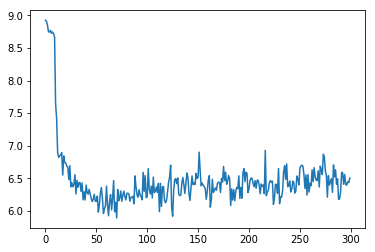

<Figure size 432x288 with 0 Axes>

In [409]:
import matplotlib.pyplot as plt

plt.plot(val_acc_history)
plt.show()

plt.savefig('val11010.png');

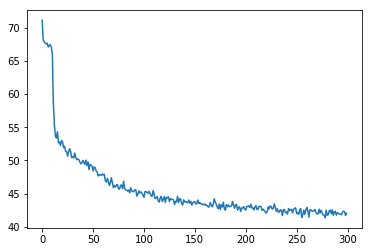

<Figure size 432x288 with 0 Axes>

In [410]:
plt.plot(train_acc_history)
plt.show()

plt.savefig('train11010.png');

### Evaluate on test data

In [411]:
enc_vid.eval()
dec_vid.eval()
enc_word.eval()
dec_word.eval()

eval_loss = []
check_similarities = True
test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=True)

similarities= {}
acc = 0
c = 0

mNNOs = []

torch.set_grad_enabled(False)

#data_size=1767
data_size=len(dataloaders_dict['test'].dataset)

vid_inputs = torch.zeros((data_size, V))
word_inputs = torch.zeros((data_size, D))
vid_to_word = torch.zeros((data_size, D))
word_to_vid = torch.zeros((data_size, V))


for data in test_dataloader:
    video = data["vid_feat"].float().to(device)
    word = data["word_feat"].float().to(device)
    label = data["label"][0]
    #print("video shape: ", video.squeeze(0).shape)
    
    try:
        mid_video = best_enc_vid(video)
    except RuntimeError as err:
        print("eror:", err)
        break
    out_video = best_dec_vid(mid_video)
    loss1 = criterion(out_video, video)

    mid_word = best_enc_word(word)
    out_word = best_dec_word(mid_word)
    loss2 = criterion(out_word, word)

    l_recons = loss1+loss2

    l_joint = criterion(mid_video, mid_word)

    cross_words = best_dec_word(mid_video)
    cross_video = best_dec_vid(mid_video)
    l_cross = criterion(cross_words, word) + criterion(cross_video, video)

    alpha1, alpha2, alpha3 = 1, 1, 1
    loss = l_recons + alpha1 * l_joint + alpha2 * l_cross
    
    #print("data: {}, \n" , c)
    #print('  mid video: {} ,  out video:{}'.format(mid_video[0][0][:5], out_video[0][0][:5]))
    #print('  mid word: {} ,  out word:{}'.format(mid_word[0][0][:5], out_word[0][0][:5]))
    
    
    vid_inputs[c]=video.squeeze(0)
    word_inputs[c]=word.squeeze(0)
    vid_to_word[c]=cross_words.squeeze(0)
    word_to_vid[c]=cross_video.squeeze(0)
    
    
    #print(loss.item())
    eval_loss.append(loss.item())
        
    if check_similarities:
        sample_word = cross_words.cpu().detach().numpy()
        sample_word = np.squeeze(np.transpose(sample_word))
        #print("samp word size:", label)
        sims = _similarity_query(word_vectors, sample_word, 30, inverse_dictionary)[1:]

        
        if label not in similarities:
            similarities[label] = [[sims]]
        else:
            similarities[label].append([sims])
        #label = "".join(label.split())
        #print(label)
        sim_words = [word_vals[0] for word_vals in sims]
        #print(len(sim_words))
        if check_match(label, sim_words):
            acc += 1
    
        #mNNO = check_neighbors(sims, label_similarities[label])
        #mNNOs.append(len(mNNO))
    c+=1
    
#print("val loss: ", np.mean(eval_loss))

In [412]:
vid_inputs.shape, word_inputs.shape, vid_to_word.shape, word_to_vid.shape

(torch.Size([1441, 1024]),
 torch.Size([1441, 300]),
 torch.Size([1441, 300]),
 torch.Size([1441, 1024]))

In [413]:
print("val loss: ", np.mean(eval_loss))

val loss:  0.5549734417584354


In [ ]:
# TEST SCORE 
np.average(mNNOs)

In [ ]:
k = [ x for x in mNNOs if x>1]
print(len(k))

In [ ]:
plt.hist(mNNOs) 

## EVALUATE MNNOs

In [414]:
import eval_utils

k_neighbors = 30
sim = 'cosine'

#perf = eval_utils.eval_performance(EMB_in=vid_inputs, EMB_out=word_inputs, EMB_map=vid_to_word, sim=sim, k_neighbors, False)
perf = eval_utils.eval_performance(vid_inputs.numpy(), word_inputs.numpy(), vid_to_word.numpy(), sim, k_neighbors, True)


print('TEST: MNNO(f(X),X)=', round(perf['mnno_map-in'],3),
                                      ' || MNNO(f(X),Y)=', round(perf['mnno_map-out'],3),
                                      ' || MNNO(Y,X)=', round(perf['mnno_in-out'],3),
                                      ' || mse=', round(perf['mse'],5), ' || R2=', round(perf['R2'],4))

TEST: MNNO(f(X),X)= 0.133  || MNNO(f(X),Y)= 0.076  || MNNO(Y,X)= 0.089  || mse= 0.07912  || R2= 0.0281


In [415]:
perf = eval_utils.eval_performance(word_inputs.numpy(), vid_inputs.numpy(), word_to_vid.numpy(), sim, k_neighbors, True)


print('TEST: MNNO(f(X),X)=', round(perf['mnno_map-in'],3),
                                      ' || MNNO(f(X),Y)=', round(perf['mnno_map-out'],3),
                                      ' || MNNO(Y,X)=', round(perf['mnno_in-out'],3),
                                      ' || mse=', round(perf['mse'],5), ' || R2=', round(perf['R2'],4))

TEST: MNNO(f(X),X)= 0.074  || MNNO(f(X),Y)= 0.136  || MNNO(Y,X)= 0.089  || mse= 0.00171  || R2= 0.0713


## Check the most similar words

In [ ]:
label_similarities = {}

for k,v in word_dict.items():
    label_similarities[k] = _similarity_query(word_vectors, v, 40, inverse_dictionary)[1:]

In [161]:
def check_match(k, sim_words, top_k=10):
    for w in sim_words[:top_k]:
        # Check direct match
        if sorted(list(w)) == sorted(list(k)):
            print("match!", w)
            return True
        # Check if any words of key is included in the similarities list
        for k_v in k.split(' '):
            #if sorted(list(w)) == sorted(list(k_v)):
            if str(w) == str(k_v):
                #print("match!", w)
                return True
        # Check if concatenation of key is included 
        k_concat = ''.join(k.split(' '))
        if str(w) == str(k):
            print("match!", w)
            return True
    return False

In [129]:
def check_neighbors(sim1, sim2):
    
    a = [x[0] for x in sim1]
    b = [x[0] for x in sim2]
    
    return set(a).intersection(b)

In [426]:
acc = 0
c = 0
top_k=1
for k, v in similarities.items():
    #print("Key: ", k, " items: ", len(v))
    for vals in v:
        sim_words = [word_vals[0] for word_vals in vals[0]]
        #print(sim_words)
        if check_match(k, sim_words, top_k=top_k):
            #print(k, " !")
            acc += 1
        c += 1
    #print(" =================================================== ")
    
print(c, " ", acc, " score: ", (acc/c)*100)

1441   32  score:  2.220680083275503


In [139]:
c, acc

(1195, 197)

0.16485355648535566

In [1108]:
similarities["yoga"]

[[[('meditation', 0.6764361198585322),
   ('pilates', 0.6524277472570437),
   ('aerobics', 0.6154991559249399),
   ('hatha', 0.6037811835067952),
   ('massage', 0.49586760563632054),
   ('workout', 0.4687201422618096),
   ('sahaja', 0.46550430333255466),
   ('meditative', 0.4642566639357688),
   ('qigong', 0.46416886138960844)]],
 [[('meditation', 0.6764361198585322),
   ('pilates', 0.6524277472570437),
   ('aerobics', 0.6154991559249399),
   ('hatha', 0.6037811835067952),
   ('massage', 0.49586760563632054),
   ('workout', 0.4687201422618096),
   ('sahaja', 0.46550430333255466),
   ('meditative', 0.4642566639357688),
   ('qigong', 0.46416886138960844)]],
 [[('meditation', 0.6764361198585322),
   ('pilates', 0.6524277472570437),
   ('aerobics', 0.6154991559249399),
   ('hatha', 0.6037811835067952),
   ('massage', 0.49586760563632054),
   ('workout', 0.4687201422618096),
   ('sahaja', 0.46550430333255466),
   ('meditative', 0.4642566639357688),
   ('qigong', 0.46416886138960844)]],
 [[(

In [1111]:
check_neighbors(most_similar(word_vectors, dct, "yoga", number=20), most_similar(word_vectors, dct, "meditation", number=20))

{'buddhism', 'meditative', 'taoist'}

In [1110]:
most_similar(word_vectors, dct, "yoga", number=10)

[('meditation', 0.6798500437828566),
 ('pilates', 0.6539306675117248),
 ('aerobics', 0.606233724916318),
 ('hatha', 0.6027756741519328),
 ('massage', 0.4880033221824527),
 ('qigong', 0.46563682669834094),
 ('sahaja', 0.460048857258116),
 ('tantra', 0.45663410031778334),
 ('meditative', 0.4563757859173338)]

# ========= RUN UNTIL THIS POINT =========

## Check a data sample

In [ ]:
print("real value: ", test_ids[0])

In [ ]:
test_video = torch.from_numpy(test_data[0]["vid_feat"]).float().to(device)
test_word = torch.from_numpy(test_data[0]["word_feat"]).float().to(device)

In [ ]:
y_pred = model(test_video)

In [ ]:
word_vector = y_pred.cpu().detach().numpy()
word_vector= np.squeeze(np.transpose(word_vector))

In [ ]:
print("Closest words to prediction: ")
_similarity_query(word_vectors, word_vector, 10, inverse_dictionary)[1:]

In [ ]:
word_vector_real = test_word.cpu().detach().numpy()
word_vector_real = np.squeeze(np.transpose(word_vector_real))

In [ ]:
print("Closest words to real label")
_similarity_query(word_vectors, word_vector_real, 10, inverse_dictionary)[1:]

## Unseen class word-embedding

In [427]:
unseen_classes=random.sample(set(action_classes_all).difference(action_classes), 30)
print(unseen_classes)

['running on treadmill', 'driving tractor', 'playing kickball', 'weaving basket', 'golf driving', 'arranging flowers', 'recording music', 'tickling', 'spraying', 'cooking egg', 'digging', 'tap dancing', 'faceplanting', 'dancing charleston', 'playing volleyball', 'answering questions', 'breading or breadcrumbing', 'playing guitar', 'using segway', 'chopping wood', 'sharpening pencil', 'dribbling basketball', 'catching or throwing baseball', 'getting a tattoo', 'skateboarding', 'making jewelry', 'blowing glass', 'barbequing', 'reading book', 'zumba']


In [428]:
unseen_classes = set(unseen_classes)
for a in unseen_classes:
    words = a.split(" ")
    glove_sums = 0
    for w in words:
        try:
            glove_sums += glove_model[w]
        except:
            print(a)
            not_exist.add(a)
            break
unseen_classes.difference_update(not_exist)

barbequing
faceplanting
breading or breadcrumbing


In [429]:
for a in unseen_classes:
    words = a.split(" ")
    glove_sums = 0
    for w in words:
        glove_sums += glove_model[w]
    glove_sums /= len(words)
    word_dict[a] = glove_sums

In [430]:
unseen_vid_features = {}
unseen_vid_ids = []
for dirpath, dirs, files in os.walk(frame_dir):
    for filename in fnmatch.filter(files, '*.npy'):
        action = filename.split("_")[0]
        if action in unseen_classes:
            rgb_sample = np.load(dirpath+filename)
            sample = torch.from_numpy(rgb_sample).unsqueeze(0)
            if sample.shape[2] > 10: # should be bigger than the kernel size 
                unseen_vid_ids.append(filename)
                # sample_var = torch.autograd.Variable(sample).to(device)
                sample_var = torch.autograd.Variable(sample)
                try:
                    out_var, _ = i3d_rgb(sample_var)
                except Exception as e: 
                    print("error: ", e)
                    print("   shape: ", sample_var.shape)
                unseen_vid_features[filename] = out_var.data.cpu().numpy()

In [431]:
label = unseen_vid_ids[150].split("_")[0]
label = label.split()
print(label)

['tap', 'dancing']


In [438]:
unseen_similarities= {}

unseen_loss=[]

for k, v in unseen_vid_features.items():
    #print(v.shape)
    
    var = torch.from_numpy(v).float().to(device)
    
    mid_video = enc_vid(var)

    out_video = dec_vid(mid_video)
    loss1 = criterion(out_video, var)

    #mid_word = enc_word(word)
    out_word = dec_word(mid_video)
    
    #sample_mapped = model(var)
    sample_word = out_word.cpu().detach().numpy()
    sample_word = np.squeeze(np.transpose(sample_word))
    #print("samp word size:", sample_word.shape )
    sims = _similarity_query(word_vectors, sample_word, 10, inverse_dictionary)[1:]
    
    label = k.split("_")[0]
    if label not in unseen_similarities:
        #print("new label", label, "\n")
        unseen_similarities[label] = [[sims]]
    else:
        unseen_similarities[label].append([sims])
    
    #print(label)
    #print(sims)
    
    #word = unseen_word_dict[label]
    #word = torch.from_numpy(word).float().to(device)
    #loss = criterion(y_pred, word)
    #unseen_loss.append(loss.item())

In [440]:
acc = 0
c = 0
top_k = 10
for k, v in unseen_similarities.items():
    #print("Key: ", k, " items: ", len(v))
    for vals in v:
        sim_words = [word_vals[0] for word_vals in vals[0]]
        #print(sim_words)
        if check_match(k, sim_words, top_k=top_k):
            #print(k, " !")
            acc += 1
        c += 1
    #print(" =================================================== ")
    
print(c, " ", acc, " score: ", (acc/c)*100)

1993   211  score:  10.58705469141997


In [434]:
for k, v in unseen_similarities.items():
    print("Key: ", k, " items: ", len(v))
    for vals in v:
        sim_words = [word_vals[0] for word_vals in vals[0]]
        print(sim_words)

Key:  reading book  items:  85
['putting', 'doing', 'instead', 'hand', 'dancing', 'like', 'you', 'started', 'just']
['hand', 'eating', 'instead', 'your', 'everything', 'you', 'tossing', 'washing', 'turning']
['putting', 'hand', 'instead', 'doing', 'you', 'your', 'like', 'everything', 'my']
['putting', 'washing', 'tossing', 'cleaning', 'cooking', 'instead', 'your', 'everything', 'hand']
['eating', 'instead', 'hand', 'everything', 'washing', 'your', 'tossing', 'you', 'walking']
['hand', 'your', 'instead', 'you', 'everything', 'doing', 'eating', 'my', 'like']
['eating', 'your', 'hand', 'you', 'fingers', 'everything', 'my', 'instead', 'talking']
['eating', 'walking', 'instead', 'you', 'like', 'picking', 'doing', 'everything', 'jumping']
['instead', 'hand', 'doing', 'walking', 'you', 'like', 'up', 'everything', 'just']
['hand', 'your', 'instead', 'you', 'eating', 'everything', 'doing', 'my', 'like']
['instead', 'hand', 'doing', 'you', 'everything', 'your', 'like', 'walking', 'up']
['putting

### 1. Cricket Shot

In [1112]:
sample_path = 'data/kinetic-samples/v_CricketShot_g04_c01_rgb.npy'
rgb_sample = np.load(sample_path).transpose(0, 4, 1, 2, 3)
sample = torch.from_numpy(rgb_sample)
print("shape now:", sample.shape)

shape now: torch.Size([1, 3, 79, 224, 224])


In [1113]:
sample_var = torch.autograd.Variable(sample).to(device)
print(sample_var.shape)
out_var, _ = i3d_rgb(sample_var)

torch.Size([1, 3, 79, 224, 224])


In [1114]:
out_var.shape

torch.Size([1, 1024])

In [1118]:
mid_video = enc_vid(out_var)
out_video = dec_vid(mid_video)



mid_word = enc_word(word)
out_word = dec_word(mid_word)

print(mid_video.shape, out_video.shape, out_word.shape)

torch.Size([1, 150]) torch.Size([1, 1024]) torch.Size([1, 1, 300])


In [1119]:
sample_word = out_word.cpu().detach().numpy()
sample_word = np.squeeze(np.transpose(sample_word))

In [1120]:
_similarity_query(word_vectors, sample_word, 10, inverse_dictionary)[1:]

[('reading', 0.8370588350649026),
 ('read', 0.7465486610683334),
 ('books', 0.7398531582532274),
 ('writing', 0.6838575261008999),
 ('published', 0.621612031251118),
 ('wrote', 0.6150002525840218),
 ('author', 0.5880179617651263),
 ('written', 0.5863053538222806),
 ('write', 0.5764967926605968)]

### 2. Drawing samples

In [ ]:
label = unseen_vid_ids[150].split("_")[0]
label = label.split()
print(label)

In [ ]:
unseen_similarities= {}

unseen_loss=[]

for k, v in unseen_vid_features.items():
    #print(v.shape)
    var = torch.from_numpy(v).float().to(device)
    sample_mapped = model(var)
    sample_word = sample_mapped.cpu().detach().numpy()
    sample_word = np.squeeze(np.transpose(sample_word))
    #print("samp word size:", sample_word.shape )
    sims = _similarity_query(word_vectors, sample_word, 10, inverse_dictionary)[1:]
    
    label = k.split("_")[0]
    if label not in unseen_similarities:
        print("new label", label, "\n")
        unseen_similarities[label] = [[sims]]
    else:
        unseen_similarities[label].append([sims])
    
    word = unseen_word_dict[label]
    word = torch.from_numpy(word).float().to(device)
    loss = criterion(y_pred, word)
    unseen_loss.append(loss.item())

In [ ]:
len(unseen_similarities.values())

In [ ]:
acc = 0
c = 0
for k, v in unseen_similarities.items():
    print("Key: ", k)
    c +=1
    for vals in v:
        sim_words = [word_vals[0] for word_vals in vals[0]]
        print(sim_words)
        if check_match(k, sim_words):
            acc += 1
    print(" =================================================== ")

# LINEAR MAPPING #

In [284]:
D

300

In [296]:
linear_mapping = nn.Linear(V, D).to(device)
linear_mapping = nn.DataParallel(linear_mapping)

num_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-5
drop_out = 0.3

optim = torch.optim.Adam(linear_mapping.parameters(), lr=learning_rate, weight_decay = weight_decay)
criterion = nn.MSELoss()

In [297]:
import time
import copy

since = time.time()

train_acc_history = []
val_acc_history = []

best_loss = 1000000.0

num_epochs=100

for epoch in range(num_epochs):

    for phase in ['train', 'val']:
        if phase == 'train':
            # Set model to training mode
            linear_mapping.train()
        else:
            linear_mapping.eval()
            
        optim.zero_grad()
        running_loss = 0.0
        
        for data in dataloaders_dict[phase]:
            
            video = data["vid_feat"].float().to(device)
            word = data["word_feat"].float().to(device)

            with torch.set_grad_enabled(phase == 'train'):
                
                #print(video.shape)
                #print(word.shape)
                
                out_word = linear_mapping(video)
                loss = criterion(out_word, word)
                running_loss += loss.item()

                if phase == 'train':
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    
        epoch_loss = running_loss #/ len(dataloaders_dict[phase].dataset)
        
        if phase == 'train':
            train_acc_history.append(epoch_loss)
        
        #loss = running_loss
        if phase == 'val':
            if epoch_loss < best_loss:
                best_loss = epoch_loss
            val_acc_history.append(epoch_loss)
            if epoch%25 ==0:
                print('epoch [{}/{}], loss:{:.8f}'
                      .format(epoch + 1, num_epochs, epoch_loss))
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_loss))

epoch [1/100], loss:0.25613388
epoch [26/100], loss:0.24182955
epoch [51/100], loss:0.22801141
epoch [76/100], loss:0.23444165
Training complete in 0m 39s
Best val Acc: 0.224706


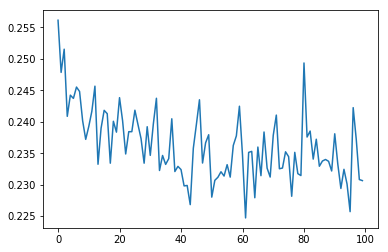

In [298]:
import matplotlib.pyplot as plt

plt.plot(val_acc_history)
plt.show()

In [299]:
linear_mapping.eval()

eval_loss = []
test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=True)

c = 0

mNNOs = []

torch.set_grad_enabled(False)

data_size=len(dataloaders_dict['test'].dataset)

vid_inputs = torch.zeros((data_size, V))
word_inputs = torch.zeros((data_size, D))
vid_to_word = torch.zeros((data_size, D))
word_to_vid = torch.zeros((data_size, V))

for data in test_dataloader:
    video = data["vid_feat"].float().to(device)
    word = data["word_feat"].float().to(device)
    
    
    out_word = linear_mapping(video)
    loss = criterion(out_word, word)
    
    #print("data: {}, \n" , c)
    #print('  mid video: {} ,  out video:{}'.format(mid_video[0][0][:5], out_video[0][0][:5]))
    #print(' out word:{}'.format(out_word[0][:5]))
    
    vid_inputs[c]=video.squeeze(0)
    word_inputs[c]=word.squeeze(0)
    vid_to_word[c]=out_word.squeeze(0)
    #word_to_vid[c]=out_video.squeeze(0)
    
    eval_loss.append(loss.item())
    c+=1

In [300]:
perf = eval_utils.eval_performance(vid_inputs.numpy(), word_inputs.numpy(), vid_to_word.numpy(), sim, k_neighbors, True)


print('TEST: MNNO(f(X),X)=', round(perf['mnno_map-in'],3),
                                      ' || MNNO(f(X),Y)=', round(perf['mnno_map-out'],3),
                                      ' || MNNO(Y,X)=', round(perf['mnno_in-out'],3),
                                      ' || mse=', round(perf['mse'],5), ' || R2=', round(perf['R2'],4))

TEST: MNNO(f(X),X)= 0.346  || MNNO(f(X),Y)= 0.109  || MNNO(Y,X)= 0.092  || mse= 0.07879  || R2= 0.0635
